In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inkml2img_pictures as ink
import pickle
import os
import time
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
import imgaug
import numpy as np
import os
import pandas as pd
import time
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# Erosion / Dilation

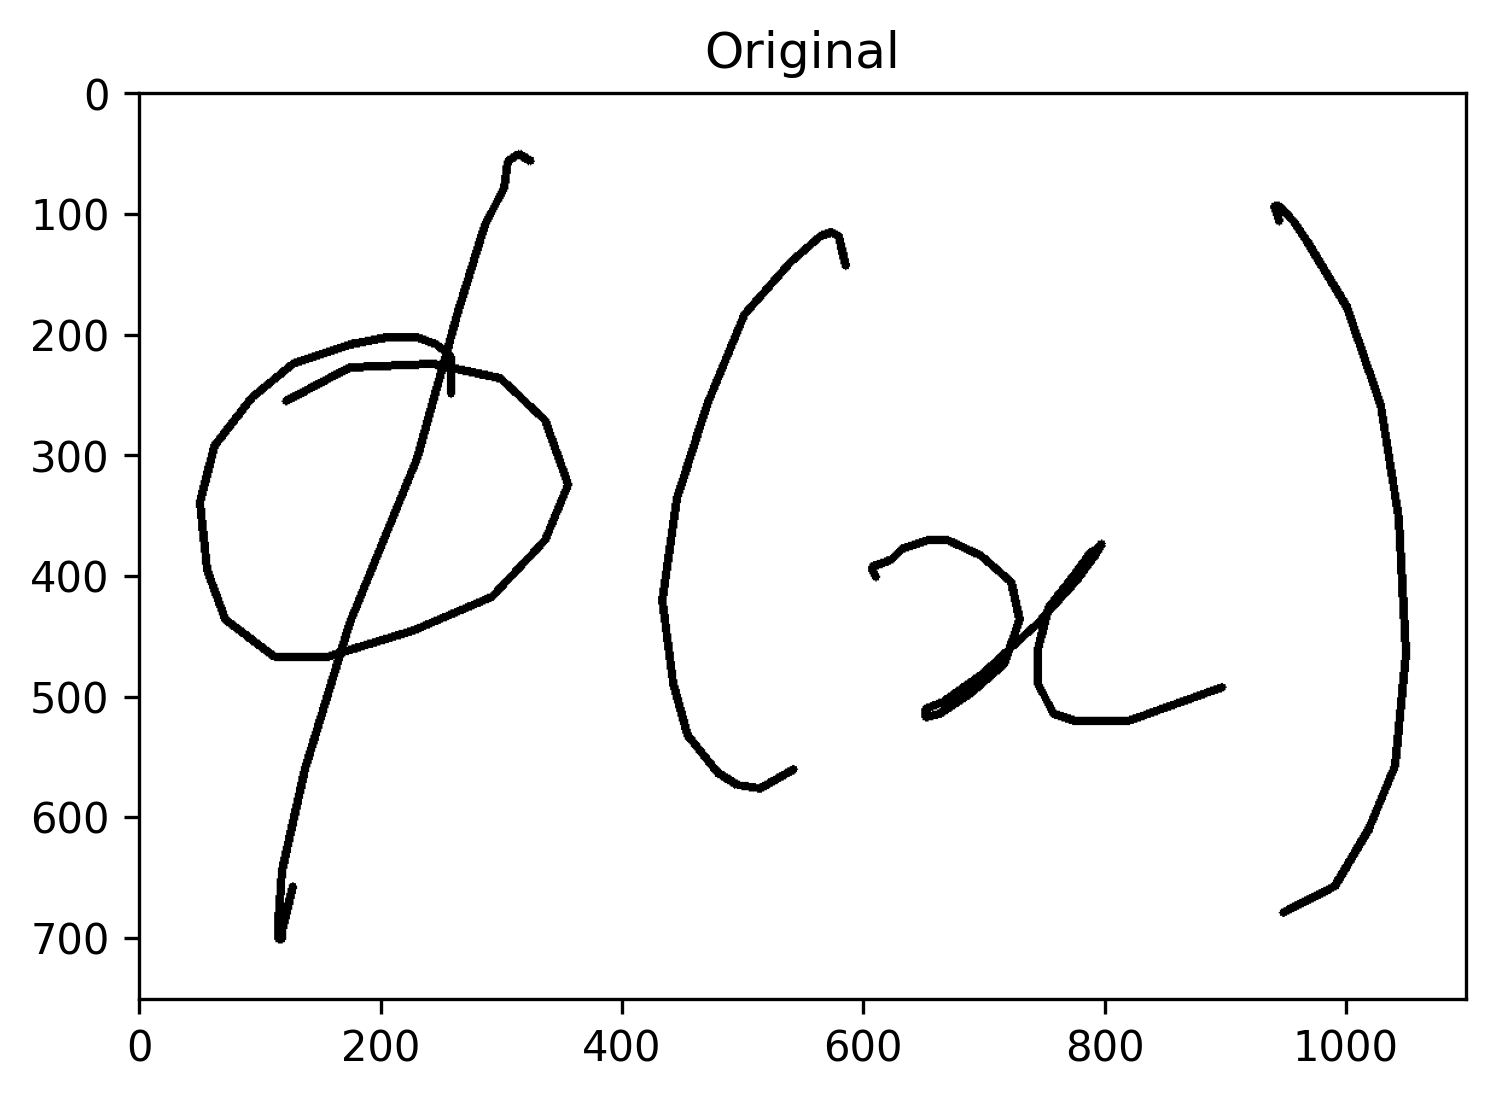

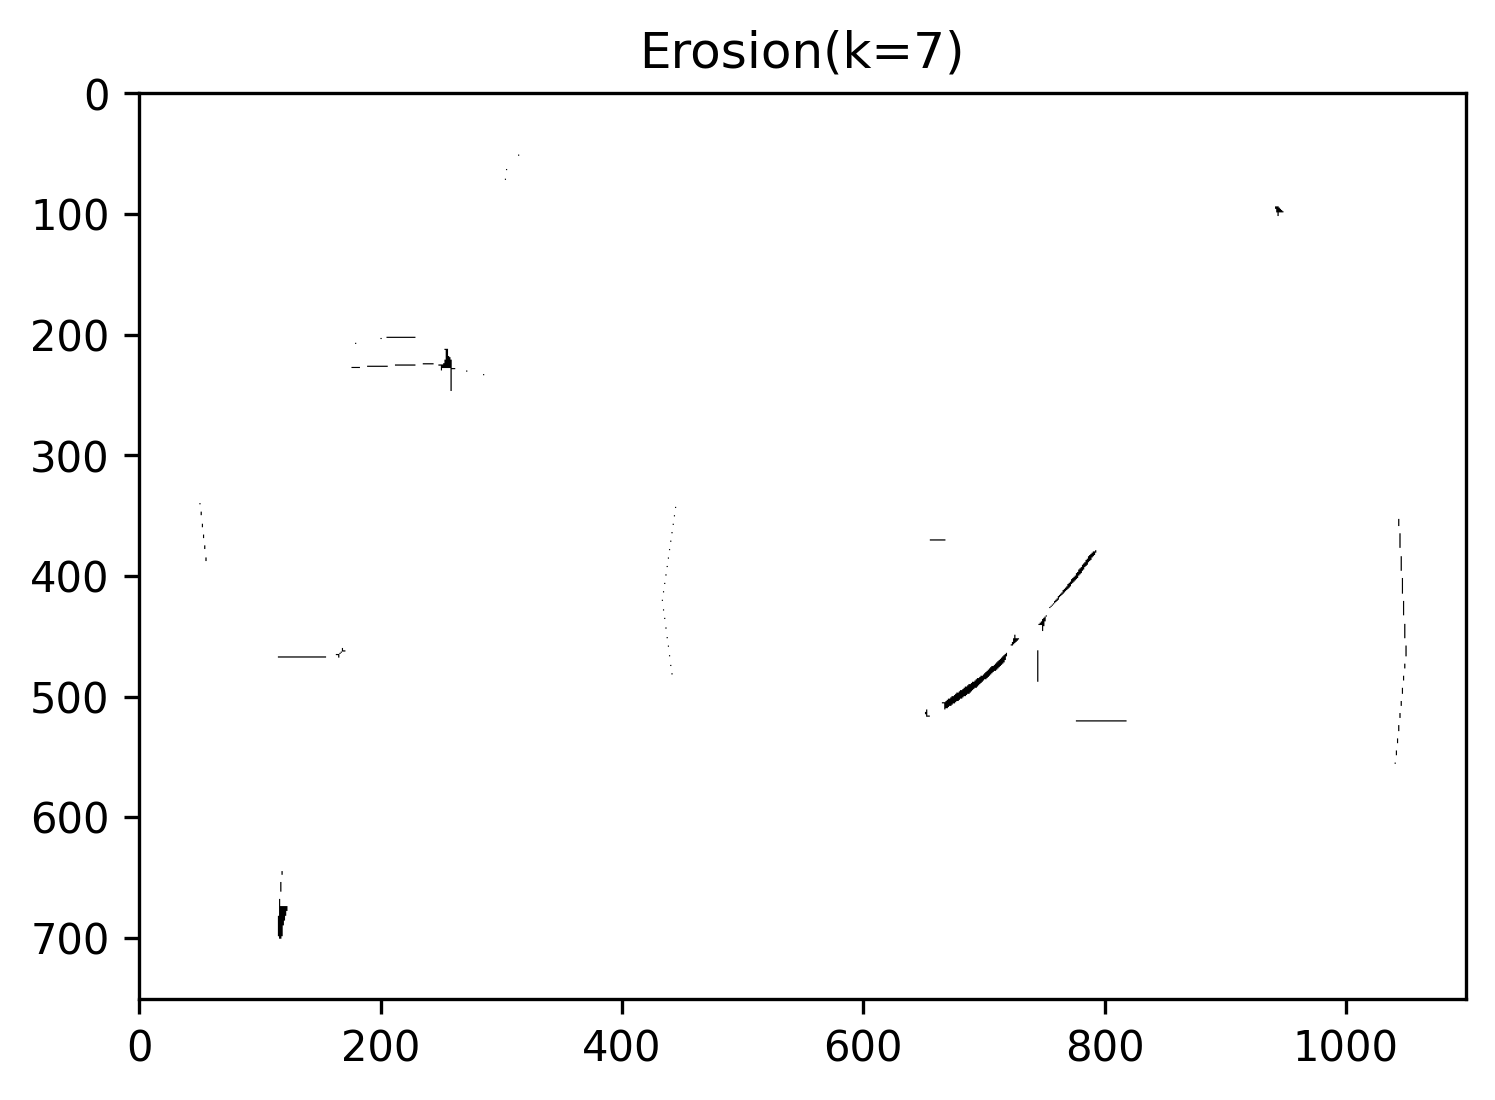

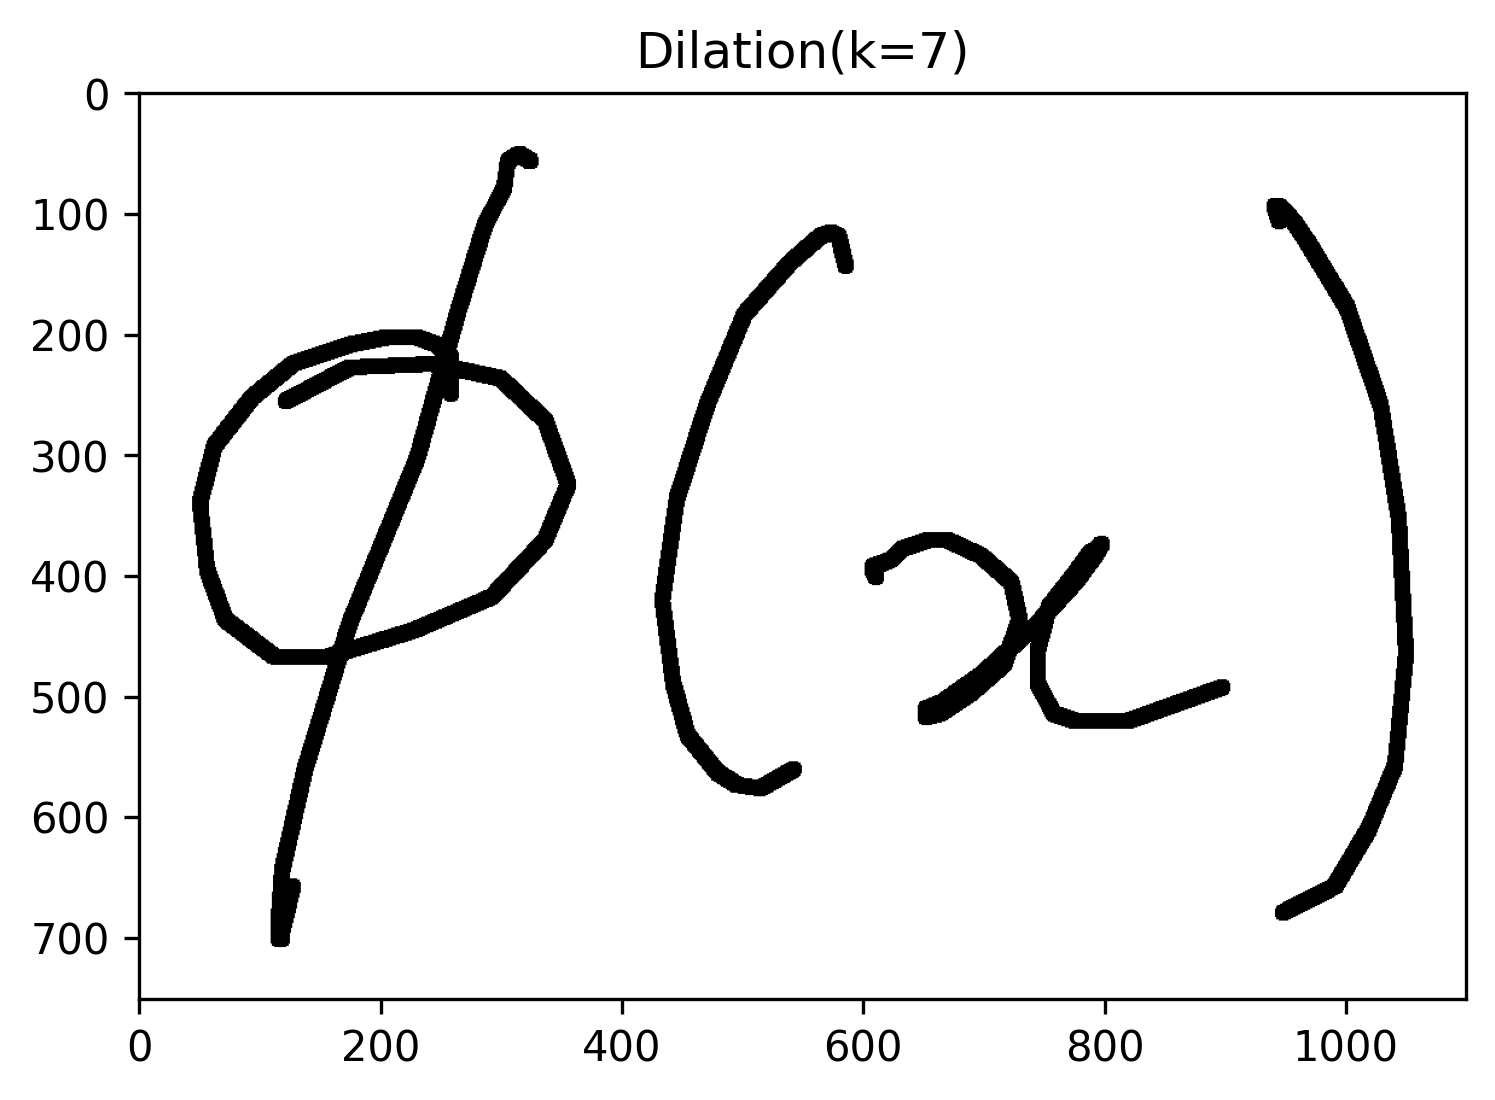

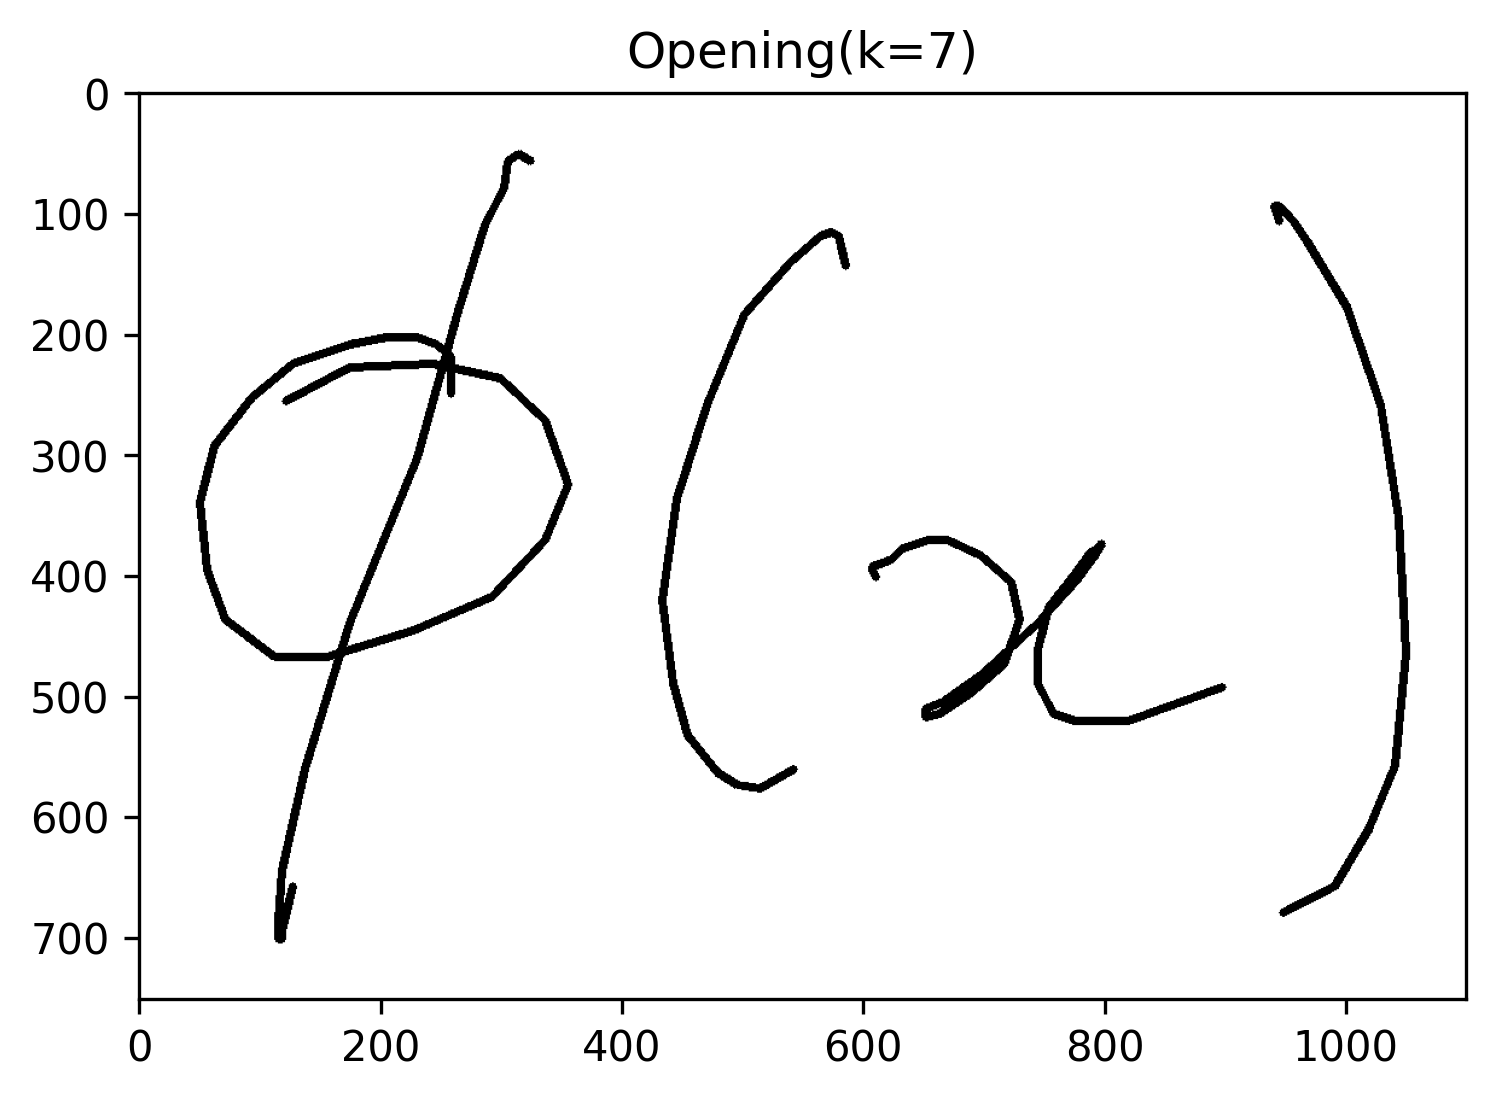

In [79]:
def invert(img):
    return ~img

def segmentation_erosion(img, k=5):
    kernel = np.ones((k,k),np.uint8)
    
    img = invert(img)
    img = cv2.erode(img, kernel, iterations = 1)
    img = invert(img)
    
    return img

def segmentation_dilation(img, k=5):    
    kernel = np.ones((k,k),np.uint8)
    
    img = invert(img)
    img = cv2.dilate(img, kernel, iterations = 1)
    img = invert(img)
    
    return img

def segmentation_opening(img, k=5):
    kernel = np.ones((k,k),np.uint8)
    
    img = invert(img)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = invert(img)
    
    return img

img = image

k = 3

plt.imshow(img, cmap='gray')
plt.title('Original')
plt.show()



plt.imshow(segmentation_dilation(img, k=k), cmap='gray')
plt.title(f'Dilation(k={k})')
plt.show()

plt.imshow(segmentation_opening(img, k=k), cmap='gray')
plt.title(f'Opening(k={k})')
plt.show()

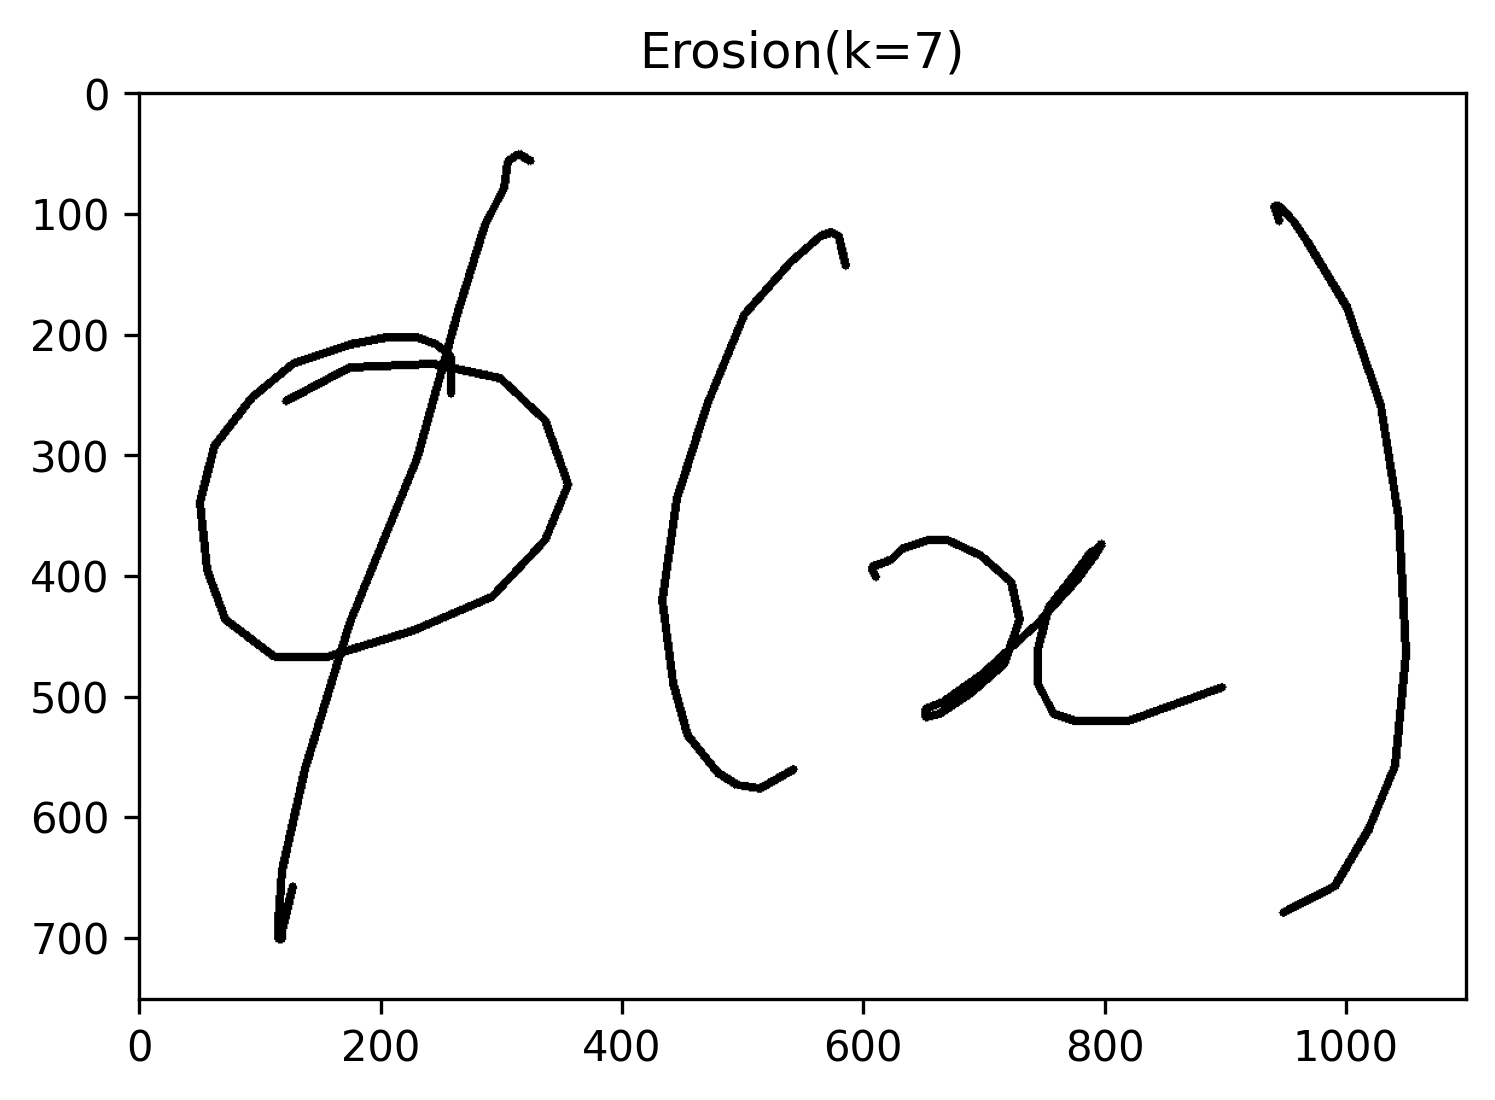

In [81]:
plt.imshow(segmentation_erosion(img, k=1), cmap='gray')
plt.title(f'Erosion(k={k})')
plt.show()

# Different Stroke Widths

In [5]:
p = os.path.join(os.getcwd(), 'data', 'tokens', 'b=96_train=2011,2013_test=2012_c=all_t=1,3,5,7,9', 'test.pickle')

In [7]:
with open(p, 'rb') as f:
    data = pickle.load(f)

In [12]:
len(data)

83526

In [35]:
g = 0
for row in data:
    if row['label'] == 17:
        g += 1

In [43]:
idx = [3, 16701, 33408, 50115, 66822]

In [64]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

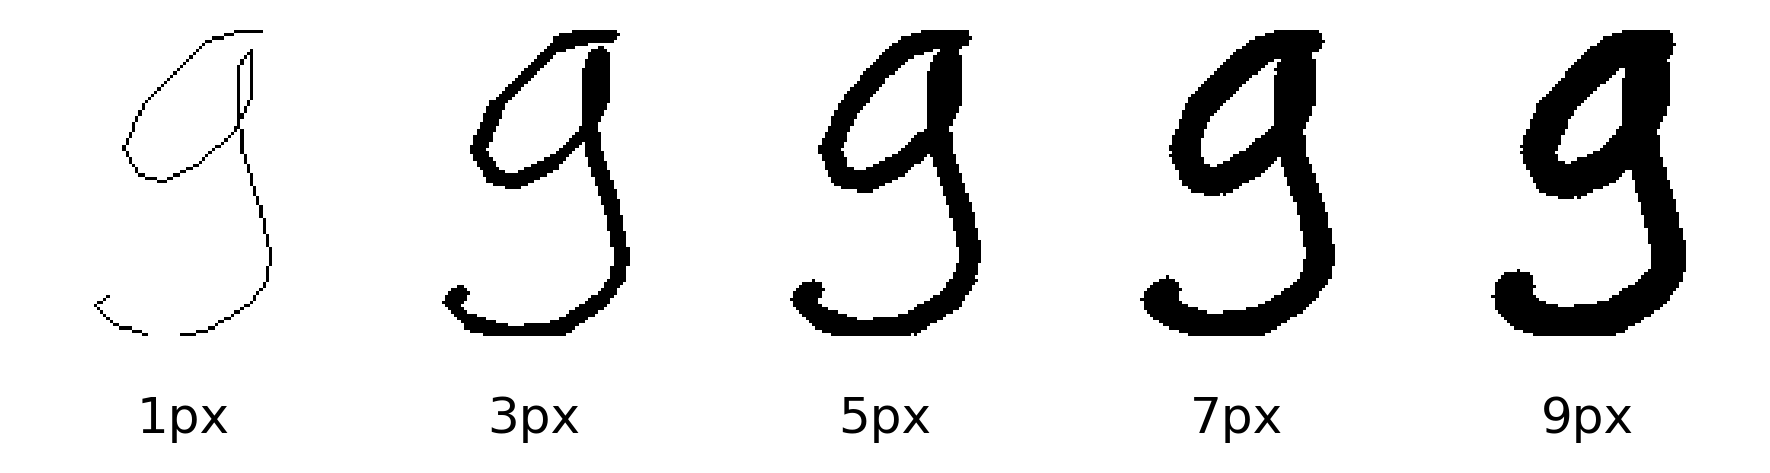

In [70]:
for j, i in enumerate(idx):
    plt.subplot(1, 5, j + 1)
    plt.axis('off')
    plt.imshow(data[i]['features'].reshape((96, 96)), cmap='gray')
    plt.title(f'{2 * j + 1}px', y=-0.4)
plt.tight_layout()
plt.show()

# Pre/Post-Linear Interpolation

In [75]:
inkml_path = os.path.join(os.getcwd(), 
                          'math', 
                          'handwritten_math_expressions_kaggle', 'CROHME_training_2011', 'formulaire001-equation001.inkml')

In [76]:
traces_data = ink.get_traces_data(inkml_path)

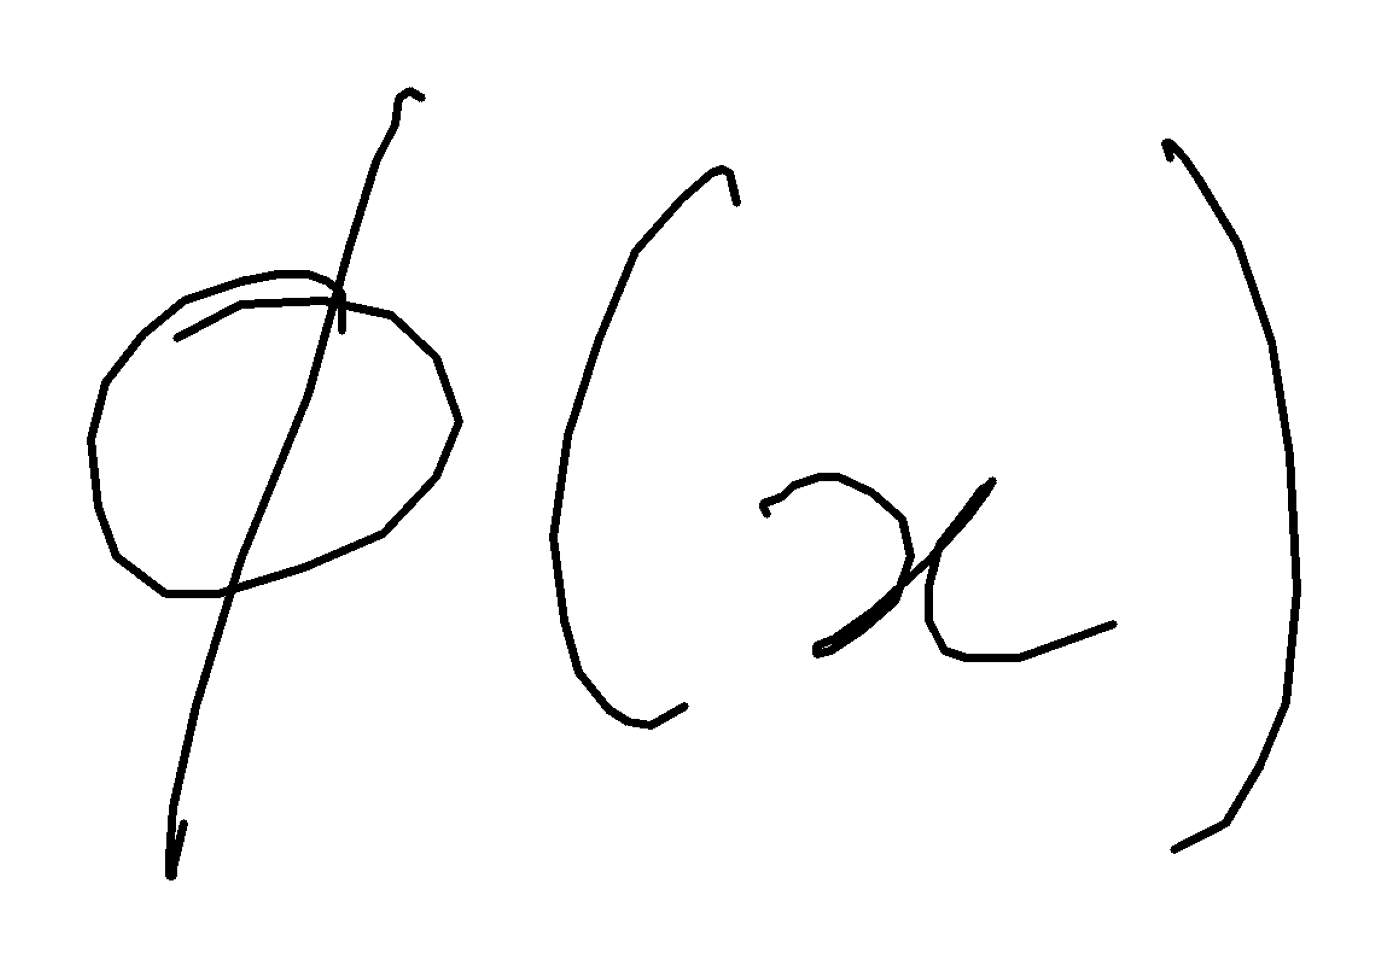

In [77]:
image, boxes = draw_traces_data(traces_data)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

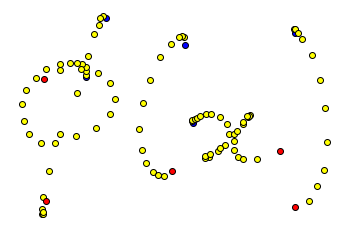

In [36]:
for row in traces_data:
    for trace in row['trace_group']:
        for i, point in enumerate(trace):
            if i == 0:
                c = 'blue'
            elif i == len(trace) - 1:
                c = 'red'
            else:
                c = 'yellow'
            plt.scatter(x=point[0], y=-point[1], c=c,edgecolors='black')
            
plt.axis('off')
plt.show()

# Connected Components Succeeding / Failing

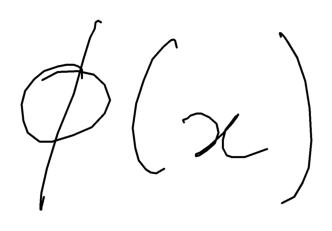

In [170]:
from matplotlib import colors

image, boxes = draw_traces_data(traces_data)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [123]:
img_color = np.zeros((image.shape[0], image.shape[1], 3))

In [124]:
for row in range(image.shape[0]):
    for col in range(image.shape[1]):
        if image[row, col] == 0:
            img_color[row, col, :] = [0, 0, 0]
        elif image[row, col] == 128:
            img_color[row, col, :] = [255, 0, 0]
        else:
            img_color[row, col, :] = [255, 255, 255]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


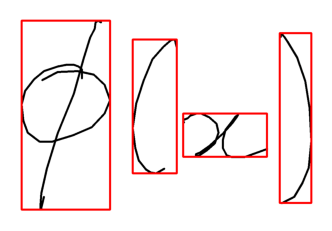

In [125]:
plt.imshow(img_color)
plt.axis('off')
plt.show()

In [171]:
bad_seg_inkml_path = os.path.join(os.getcwd(), 
                          'math', 
                          'handwritten_math_expressions_kaggle', 'TrainINKML_2013', 'TrainINKML', 'extension', '3_em_18.inkml')

In [172]:
traces_data = ink.get_traces_data(bad_seg_inkml_path)
image, boxes = draw_traces_data(traces_data)

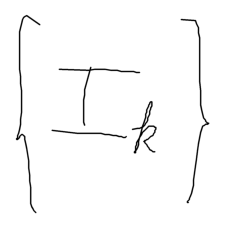

In [173]:
image, boxes = draw_traces_data(traces_data)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [164]:
image_size=96

In [166]:
for img, rect in image_to_components(image):
    rect_x_min, rect_y_min, rect_width, rect_height = rect
    
    image = cv2.rectangle(image, 
                      (int(rect_x_min), int(rect_y_min)), 
                      (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
                      (128), 
                      5)

ran cv2 connected components


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


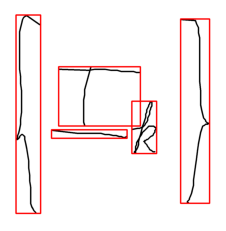

In [167]:
img_color = np.zeros((image.shape[0], image.shape[1], 3))

for row in range(image.shape[0]):
    for col in range(image.shape[1]):
        if image[row, col] == 0:
            img_color[row, col, :] = [0, 0, 0]
        elif image[row, col] == 128:
            img_color[row, col, :] = [255, 0, 0]
        else:
            img_color[row, col, :] = [255, 255, 255]
            
plt.imshow(img_color)
plt.axis('off')
plt.show()

In [7]:
image_size = 96

In [8]:
import cv2

class ExpressionImageDataset(Dataset):
    """
    An expression-level dataset.
    """
    def __init__(self, pickle_file, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))
            
#         print(self.df_data)

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df_data.iloc[idx]
                
        traces_data = row['traces_data']
        img_path = row['img_path']
        tokens = row['tokens']
        latex = row['latex']
        
        # CV2 will read the image with white being 255 and black being 0, but since
        # our token-level training set uses binary arrays to represent images, we
        # need to binarize our image here as well.
        image_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_binarized = cv2.threshold(image_raw, 127, 255, cv2.THRESH_BINARY)[1]
        image_bitmap = image_binarized / 255.0
        
        sample = {
            'image': image_binarized,
            'image_bitmap': image_bitmap,
            'traces_data': traces_data,
            'tokens': tokens,
            'latex': latex
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
train_exp_path = os.path.join(os.getcwd(), 'data', 'train=2011,2013_test=2012', 'train', 'train.pickle')
test_exp_path = os.path.join(os.getcwd(), 'data', 'train=2011,2013_test=2012', 'test', 'test.pickle')

# print('train')
train_exp_set = ExpressionImageDataset(train_exp_path)
# print('test')
test_exp_set = ExpressionImageDataset(test_exp_path)

In [149]:
def image_to_components(img):
    """
    Identifies the connected components (groups of black pixels) within an image.
    Returns a list of tuples. The first element of each tuple is the component
    image, and the second element is a tuple representing the bounding box of the
    component (relative to the original image dimensions).
    """
    
    # Invert the image because for CV2, foreground objects should be white, and the background black.
    img_flipped = cv2.bitwise_not(img)

    # cv2.connectedComponents returns a mask of the input where each element is a number from 0
    # to num_labels. All the 0's are considered the same component, 1's together, so on and
    # so forth.
    num_labels, labeled_img = cv2.connectedComponents(img_flipped)
    
    print('ran cv2 connected components')

    components = []

    # Skip the first component because it will be the background.
    for l in range(1, num_labels):
        mask = np.zeros(labeled_img.shape, dtype=np.uint8)
        mask[labeled_img == l] = 255

        rect = cv2.boundingRect(mask)

    #     # Draw bounding box to make sure it's correct.
    #     cv2.rectangle(mask, (x, y), (x + w, y + h), (36,255,12), 2)

        mask = cv2.bitwise_not(mask)

        components.append((mask, rect))

    components.sort(key=lambda c: (c[1][0], c[1][1]))

#     for mask, rect in components:    
#         plt.imshow(mask, cmap='gray')
#         plt.show()
        
    return components

In [140]:
def process_component(image, bounding_rect):
    """
    Processes a component image so it can be fed into the CNN for as input.
    It crops the component, pads the cropped image so that it's square, and
    then resizes it to the shape the CNN expects.
    
    Args:
        image - Image containing a single component.
        bounding_rect - Tuple defining the bounding box of the component.
    """
    
    x, y, w, h = bounding_rect
    
    # Crop the image to just the bounding box.
    image = image[y: y + h, x: x + w]
    
    # Pad the image so it's square.
    if w > h:
        pad = int((w - h) / 2)        
        image = cv2.copyMakeBorder(image, 
                                   top=pad, 
                                   bottom=pad, 
                                   left=0, 
                                   right=0, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    else:
        pad = int((h - w) / 2)
        image = cv2.copyMakeBorder(image, 
                                   top=0, 
                                   bottom=0, 
                                   left=pad, 
                                   right=pad, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    
    # Scale down to the correct size. Seems like cv2.INTER_AREA is the best
    # interpolation method for maintaining stroke wdith.
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    
    # During the resize some pixels will get scaled to be between 0 (black) and 255 (white).
    # In order to maintain stroke width, we set all non-white pixels to full black.
    # If we don't do this the resulting image ends up looking rather sparse.
    # We also convert the image to binary so that it's ready for the model.
    image = (image == 255).astype(int)
    
    return image

(322, 483)


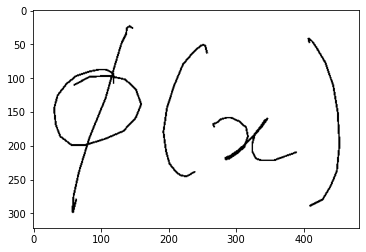

(30, 22, 131, 278)


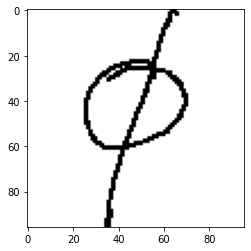

(191, 50, 68, 197)


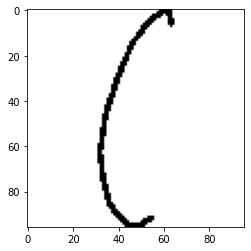

(265, 158, 125, 65)


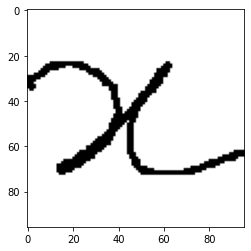

(405, 41, 49, 250)


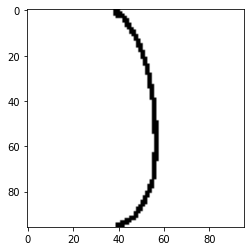

In [12]:
# Example code.
test_img = train_exp_set[0]['image']

print(test_img.shape)
plt.imshow(test_img, cmap='gray')
plt.show()

components = image_to_components(test_img)

for img, rect in components:
    print(rect)
    
    out = process_component(img, rect)
    plt.imshow(out, cmap='gray')
    plt.show()

In [ ]:
test_traces_data = train_exp_set[0]['traces_data']

In [72]:
def get_traces_data_stats(traces_data):
    all_coords = []
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            all_coords.extend(trace)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height

def get_trace_group_bounding_box(trace_group):
    all_coords = []
    for t in trace_group:
        all_coords.extend(t)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height
    

def draw_traces_data(traces_data):
    im_x_min, im_y_min, width, height = get_traces_data_stats(traces_data)
    
    # Scale the image down.
    max_dim = 1000 # Maximum dimension pre-pad.
    sf = 1000 / max(height, width)
    scaled_height = int(height * sf)
    scaled_width = int(width * sf)
    
    image = np.ones((scaled_height, scaled_width))
    
    # Pad the scaled image. We pad the image first before we draw the traces, because it's possible that
    # for certain stroke widths, part of the expression would be cut off. Adding (enough) padding before 
    # drawing prevents this issue.
    pad_factor = 0.05
    pad_amount = int(max(pad_factor * scaled_width, pad_factor * scaled_height))
    pad_width = ((pad_amount, pad_amount), (pad_amount, pad_amount))
    image = np.pad(image, 
                     pad_width=pad_amount, 
                     mode='constant', 
                     constant_values=1)
        
    # Draw the traces on the scaled/padded image.
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            trace = np.array(trace)
            trace -= np.array([im_x_min, im_y_min])
            trace = (trace.astype(np.float64) * sf).astype(int)
            trace += int(pad_factor * scaled_width)  # Remove.
            
            for coord_idx in range(1, len(trace)):
                cv2.line(image, tuple(trace[coord_idx - 1]), tuple(trace[coord_idx]), color=(0), thickness=5)
    
    # Binarize.
    image = (image > 0).astype(int) 
    
    # Open CV wants images to be between 0 and 255.
    image *= 255
    image = image.astype(np.uint8)
    
    boxes = []
    
    # Get bounding boxes.
    for pattern in traces_data:
        trace_group = pattern['trace_group']
        rect_x_min, rect_y_min, rect_width, rect_height = get_trace_group_bounding_box(trace_group)
        
        rect_x_min = (rect_x_min - im_x_min) * sf + pad_width[1][0]
        rect_y_min = (rect_y_min - im_y_min) * sf + pad_width[0][0]
        
        rect_width *= sf
        rect_height *= sf
        
        # Convert bounding box coords to integers.
        rect_x_min = int(rect_x_min)
        rect_y_min = int(rect_y_min)
        rect_width = int(rect_width)
        rect_height = int(rect_height)
              
        # Draw the rectangle.
#         image = cv2.rectangle(image, 
#                               (int(rect_x_min), int(rect_y_min)), 
#                               (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
#                               (128), 
#                               5)
        
        boxes.append((rect_x_min, rect_y_min, rect_width, rect_height))
    
#     plt.imshow(image, cmap='gray')
#     plt.show()
    
    return image, boxes
    

In [9]:
image, boxes = draw_traces_data(test_traces_data)
plt.imshow(image, cmap='gray')
print(image.shape)
print(boxes)

NameError: name 'test_traces_data' is not defined